In [1]:
# 03_data_encoding.ipynb
# Encodes the event log

In [2]:
### IMPORT ###
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### LOCAL IMPORT ###
from config import config_reader

In [4]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
# print(yaml_config) # debug
data_log_dir = str(yaml_config['DATA_LOG_DIR'])
data_log_encoded_dir = str(yaml_config['DATA_LOG_ENCODED_DIR'])
data_file = "EVENT-LOG_ED_filtered_DIM.csv" # input (DIM vary by prefix length)
# event log columns
log_key_col = str(yaml_config['LOG_KEY_COL'])
log_feature_col = list(yaml_config['LOG_FEATURE_COL'])
log_outcome_col = str(yaml_config['LOG_OUTCOME_COL'])
log_outcome_col_values = list(yaml_config['LOG_OUTCOME_COL_VALUES'])
# prefix length
prefix_min = int(yaml_config['PREF_MIN_VALUE'])
prefix_max = int(yaml_config['PREF_MAX_VALUE'])
prefix_list = list(range(prefix_min, prefix_max + 1)) 
# encoding
encoding = "I" # input -> B = binary, F = Frequency, I = simple Index

### FUNCTIONS ###

In [5]:
def plot_h(results_df:pd.DataFrame):
    # Bar colors
    colors = ['skyblue', 'lightcoral'] * (len(results_df) // 2 + 1)
    colors = colors[:len(results_df)]
    # Figure
    plt.figure(figsize=(5, 3))
    plt.barh(results_df['Outcome'], results_df['Cases'], color=colors)
    plt.xlabel('Cases')
    plt.ylabel('Outcome')
    plt.title('Number of Cases per Outcome')
    plt.show()

In [6]:
def binary_encoding(df: pd.DataFrame, activity_col:str) -> pd.DataFrame:
    """
    Parameters:
        df (pd.DataFrame): The input dataframe containing the event log to be encoded.
        activity_col (str): The name of the column representing activities.

    Returns:
        pd.DataFrame: A dataframe with the 'activity_col' column in binary encoding.
    """
    df_encoded = pd.get_dummies(df, columns=[activity_col], prefix=[activity_col], dtype=int)
    return df_encoded

In [7]:
def frequency_encoding(df: pd.DataFrame, case_col:str, activity_col:str, timestamp_col:str) -> pd.DataFrame:
    """
    Adds cumulative frequency encoding of activities for each CaseID up to the current TIMESTAMP.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the event log to be encoded.

    Returns:
        pd.DataFrame: A dataframe with the original columns plus the cumulative frequency of activities for each CaseID up to the current TIMESTAMP.
    """
    
    # Ensure TIMESTAMP is in datetime format
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Sort the dataframe by CaseID and TIMESTAMP
    df = df.sort_values(by=[case_col, timestamp_col])

    # Calculate cumulative counts of activities
    cumulative_counts = df.groupby([case_col, activity_col]).cumcount() + 1

    # Create a pivot table to get cumulative counts as columns
    pivot_df = df.assign(count=cumulative_counts).pivot_table(index=[case_col, timestamp_col], columns=activity_col, values='count', fill_value=0).reset_index()

    # Add prefix ACTIVITY_ to activity columns
    pivot_df = pivot_df.rename(columns=lambda x: f'ACTIVITY_{x}' if x not in [case_col, timestamp_col] else x)

    # Merge the cumulative counts with the original dataframe
    merged_df = df.merge(pivot_df, on=[case_col, timestamp_col], how='left')

    # Ensure the frequency counts are all integers
    activity_columns = [col for col in merged_df.columns if col.startswith('ACTIVITY_')]
    merged_df[activity_columns] = merged_df[activity_columns].astype(int)

    return merged_df

In [8]:
def index_encoding(df:pd.DataFrame, case_col:str, activity_col:str, timestamp_col:str) -> pd.DataFrame:
    """
    Perform index encoding on the given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the event log to be encoded. 
        case_col (str): The name of the column representing case IDs.
        activity_col (str): The name of the column representing activities.
        timestamp_col (str): The name of the column representing timestamps.

    Returns:
        pd.DataFrame: A DataFrame with index encoding where each activity is a column with values indicating the order of appearance in each case.
    """
    
    # Sort the DataFrame by case ID and timestamp
    df_sorted = df.sort_values(by=[case_col, timestamp_col])

    # Group by case ID and apply a counter for each activity
    df_sorted['ACTIVITY_ORDER'] = df_sorted.groupby(case_col).cumcount() + 1

    # Create a column for each activity with the index of its occurrence
    for activity in df[activity_col].unique():
        activity_mask = df_sorted[activity_col] == activity
        df_sorted[f'ACTIVITY_{activity}'] = activity_mask.astype(int) * df_sorted['ACTIVITY_ORDER']

    # Fill NaN with 0 and convert to integer
    activity_columns = [col for col in df_sorted.columns if col.startswith('ACTIVITY_')]
    df_sorted[activity_columns] = df_sorted[activity_columns].fillna(0).astype(int)
    
    # Drop the temporary 'ACTIVITY_ORDER' column and the original activity_col
    df_final = df_sorted.drop(columns=['ACTIVITY_ORDER',activity_col])
    
    return df_final

In [9]:
def df_reorder_columns(df:pd.DataFrame, case_col:str, timestamp_col:str, outcome_col:str) -> pd.DataFrame:
    """
    Reorders the columns of the DataFrame with the following order: CaseID, TIMESTAMP, all other columns, OUTCOME.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame to reorder.
    
    Returns:
        pd.DataFrame: The DataFrame with reordered columns.
    """
    # List of all columns in the DataFrame
    columns = list(df.columns)
    
    # Remove CaseID, TIMESTAMP, and OUTCOME from the list of columns
    columns.remove(case_col)
    columns.remove(timestamp_col)
    columns.remove(outcome_col)
    
    # Create the new columns order list
    new_columns_order = [case_col, timestamp_col] + columns + [outcome_col]
    
    # Reorder the DataFrame columns
    df_reordered = df[new_columns_order]
    
    return df_reordered

### MAIN ###

In [10]:
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()


*** PROGRAM START ***

Start process: 2024-05-31 09:48:59



In [11]:
print(">> Reading event log prefixes")
print()
print("Prefix list:", prefix_list)
print()
for prefix_size in prefix_list:
    print("> Prefix size:", prefix_size)
    data_file = data_file.replace("DIM", str(prefix_size))
    path_data = Path(data_log_dir) / data_file
    print("> Reading:", path_data)
    df_log = pd.read_csv(path_data, sep = ";")
    print("Initial data shape:", df_log.shape) # rows x cols
    print("Event log columns (features):", df_log.columns) 

>> Reading event data


FileNotFoundError: [Errno 2] No such file or directory: 'data_log/EVENT-LOG_ED_filtered_DIM.csv'

In [ ]:
df_log

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP
0,2022090004,TRIAGE,2022-09-01 01:11:31,NURS_0,3,A domicilio,-
1,2022090004,PRESA IN CARICO,2022-09-01 01:25:00,DOCT_3,3,A domicilio,-
2,2022090004,LABORATORIO,2022-09-01 01:29:49,-,3,A domicilio,-
3,2022090004,CONSULENZA,2022-09-01 02:46:20,-,3,A domicilio,-
4,2022090004,DIMISSIONE,2022-09-01 02:48:00,-,3,A domicilio,-
...,...,...,...,...,...,...,...
5824,2022093471,DIMISSIONE,2022-09-30 23:44:00,-,4,A domicilio,-
5825,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-
5826,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-
5827,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-


>> Information on event log

Cases (distinct 'CaseID' values): 701

Column 'ACTIVITY' distinct values cardinality: 39
Column 'TIMESTAMP' distinct values cardinality: 4826
Column 'RESOURCE' distinct values cardinality: 94
Column 'ESI' distinct values cardinality: 5
Column 'INPAT-HOSP-DEP' distinct values cardinality: 23

Column 'OUTCOME' distinct values: ['A domicilio' 'Ricoverato']
Column 'OUTCOME' distinct values cardinality: 2

Cases for outcome 'A domicilio': 410
Cases for outcome 'Ricoverato': 291


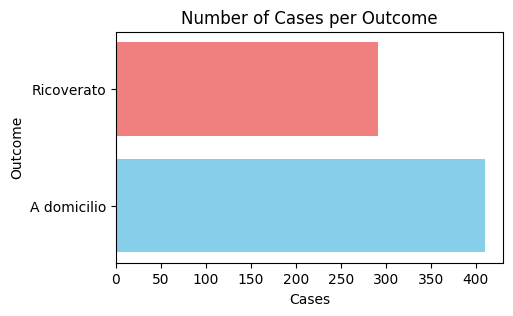

In [ ]:
print(">> Information on event log")
print()

# Number of distinct cases
cases_num = df_log[log_key_col].nunique()
print(f"Cases (distinct '{log_key_col}' values): {cases_num}")
print()

# Features distinct values and cardinality
for feature_col in log_feature_col:
    # print(f"Column '{feature_col}' values: {df_data[feature_col].unique()}")
    print(f"Column '{feature_col}' distinct values cardinality: {df_log[feature_col].nunique()}")
print()

# Outcome distinct values and cardinality
print(f"Column '{log_outcome_col}' distinct values: {df_log[log_outcome_col].unique()}")
print(f"Column '{log_outcome_col}' distinct values cardinality: {df_log[log_outcome_col].nunique()}")
print()

# Cases vs outcome distribution
results_outcome = []
for outcome_value in log_outcome_col_values:
    df_filtered = df_log[df_log[log_outcome_col] == outcome_value]
    cases = df_filtered[log_key_col].nunique()
    results_outcome.append((outcome_value, cases))
    print(f"Cases for outcome '{outcome_value}': {cases}")

# Creating a DataFrame from results
results_df = pd.DataFrame(results_outcome, columns=['Outcome', 'Cases'])
plot_h(results_df)

In [ ]:
# Columns to be used in the encoding phase
print(">> Selecting columns (features) for the event log")
col_enc = [log_key_col, 'ACTIVITY', 'TIMESTAMP', log_outcome_col] # colums to be used for encoding and prediction
df_log = df_log[col_enc]
print("Columns:", df_log.columns)

>> Selecting columns (features) for the event log
Columns: Index(['CaseID', 'ACTIVITY', 'TIMESTAMP', 'OUTCOME'], dtype='object')


In [ ]:
df_log

,CaseID,ACTIVITY,TIMESTAMP,OUTCOME
0,2022090004,TRIAGE,2022-09-01 01:11:31,A domicilio
1,2022090004,PRESA IN CARICO,2022-09-01 01:25:00,A domicilio
2,2022090004,LABORATORIO,2022-09-01 01:29:49,A domicilio
3,2022090004,CONSULENZA,2022-09-01 02:46:20,A domicilio
4,2022090004,DIMISSIONE,2022-09-01 02:48:00,A domicilio
...,...,...,...,...
5824,2022093471,DIMISSIONE,2022-09-30 23:44:00,A domicilio
5825,2022093479,TRIAGE,2022-09-30 23:58:38,A domicilio
5826,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,A domicilio
5827,2022093479,LABORATORIO,2022-10-01 01:00:12,A domicilio


In [ ]:
print(">> Encoding")
print("> Encoding the outcome")
outcome_mapping = {"A domicilio": 0, "Ricoverato": 1}  
df_log = df_log.copy() 
df_log["OUTCOME_BIN"] = df_log[log_outcome_col].map(outcome_mapping)
df_log = df_log.drop(columns=[log_outcome_col]) # drop the old outcome in str format
df_log = df_log.rename(columns={"OUTCOME_BIN": log_outcome_col})

>> Encoding
> Encoding the outcome


In [ ]:
df_log

,CaseID,ACTIVITY,TIMESTAMP,OUTCOME
0,2022090004,TRIAGE,2022-09-01 01:11:31,0
1,2022090004,PRESA IN CARICO,2022-09-01 01:25:00,0
2,2022090004,LABORATORIO,2022-09-01 01:29:49,0
3,2022090004,CONSULENZA,2022-09-01 02:46:20,0
4,2022090004,DIMISSIONE,2022-09-01 02:48:00,0
...,...,...,...,...
5824,2022093471,DIMISSIONE,2022-09-30 23:44:00,0
5825,2022093479,TRIAGE,2022-09-30 23:58:38,0
5826,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,0
5827,2022093479,LABORATORIO,2022-10-01 01:00:12,0


In [ ]:
print("> Encoding the activity column")
print("Encoding type:", encoding)
if encoding == "B":
    df_encoded = binary_encoding(df_log, log_key_col, "ACTIVITY", "TIMESTAMP")
if encoding == "F":
    df_encoded = frequency_encoding(df_log, log_key_col, "ACTIVITY", "TIMESTAMP")
if encoding == "I":
    df_encoded = index_encoding(df_log, log_key_col, "ACTIVITY", "TIMESTAMP")

# Reorder the columns
df_encoded = df_reorder_columns(df_encoded, log_key_col, "TIMESTAMP", log_outcome_col)

> Encoding the activity column
Encoding type: I


In [ ]:
df_encoded

,CaseID,TIMESTAMP,ACTIVITY_TRIAGE,ACTIVITY_PRESA IN CARICO,ACTIVITY_LABORATORIO,ACTIVITY_CONSULENZA,ACTIVITY_DIMISSIONE,ACTIVITY_ELETTROCARDIOGRAMMA,ACTIVITY_RX THORAX / TH+LAT,ACTIVITY_ECOGRAF.RENOVESCICALE,...,ACTIVITY_COLONSCOPIA CON ENDOSCOPIO FLESSIBILE,ACTIVITY_EMODIAFILTRAZIONE,ACTIVITY_EGA VENOSO,ACTIVITY_BRONCOSCOPIA CON FIBRE OTTICHE,ACTIVITY_TEST DA SFORZO,ACTIVITY_NARCOSI,ACTIVITY_VALUTAZIONE MULTIDISCIPLINARE,ACTIVITY_CONTROLLO PM-ICD-LOOP,ACTIVITY_FASCIATURA SEMPLICE,OUTCOME
0,2022090004,2022-09-01 01:11:31,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022090004,2022-09-01 01:25:00,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022090004,2022-09-01 01:29:49,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022090004,2022-09-01 02:46:20,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022090004,2022-09-01 02:48:00,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824,2022093471,2022-09-30 23:44:00,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5825,2022093479,2022-09-30 23:58:38,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5826,2022093479,2022-10-01 00:51:00,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5827,2022093479,2022-10-01 01:00:12,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(">> Saving the event log encoded")
# ordering
final_sampled_df = df_encoded.sort_values(by = ["CaseID", "TIMESTAMP"])
file_out = f"{Path(data_file).stem}_{encoding}.csv" # get the input file name and add "_filtered"
path_out = Path(data_log_encoded_dir) / file_out
print("Path:", path_out)
final_sampled_df.to_csv(path_out, sep=";", index=False)

>> Saving the event log encoded
Path: data_log_encoded/EVENT-LOG_ED_filtered_I.csv


In [ ]:
# program END
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print()
print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()